In [1]:
# imports
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import scipy.stats as sstats
from os.path import join, exists
from sklearn.metrics import matthews_corrcoef

In [2]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [3]:
df = pd.read_csv(join(PROJ_DIR, DATA_DIR, "data.csv"), index_col=0, header=0)

In [4]:
df.drop(list(df.filter(regex='lesion.*').columns), axis=1, inplace=True)

In [5]:
no_2yfu = df[df["interview_date.2_year_follow_up_y_arm_1"].isna() == True].index
df = df.drop(no_2yfu, axis=0)

In [6]:
deltasmri_complete = pd.concat([df.filter(regex='smri.*change_score'), 
                                df.filter(regex='mrisdp.*change_score')], axis=1).dropna()
deltarsfmri_complete = df.filter(regex='rsfmri.*change_score').dropna(how='any')
deltarsi_complete = df.filter(regex='dmri_rsi.*change_score').dropna()
deltadti_complete = df.filter(regex='dmri_dti.*change_score').dropna()

In [7]:
print(f'smri cols: {len(deltasmri_complete.columns)}')
print(f'rsfmri cols: {len(deltarsfmri_complete.columns)}')
print(f'rsi cols: {len(deltarsi_complete.columns)}')
print(f'dti cols: {len(deltadti_complete.columns)}')


smri cols: 785
rsfmri cols: 758
rsi cols: 122
dti cols: 111


In [8]:
imaging_qc = [
    "imgincl_dmri_include.baseline_year_1_arm_1",
    "imgincl_rsfmri_include.baseline_year_1_arm_1",
    "imgincl_t1w_include.baseline_year_1_arm_1",
    "imgincl_t2w_include.baseline_year_1_arm_1",
    "imgincl_dmri_include.2_year_follow_up_y_arm_1",
    "imgincl_rsfmri_include.2_year_follow_up_y_arm_1",
    "imgincl_t1w_include.2_year_follow_up_y_arm_1",
    "imgincl_t2w_include.2_year_follow_up_y_arm_1",
]
nihtb = [
    "nihtbx_picvocab_uncorrected.change_score",
    #"nihtbx_flanker_uncorrected.change_score",
    #'nihtbx_list_uncorrected.change_score',
    #'nihtbx_cardsort_uncorrected.change_score',
    "nihtbx_pattern_uncorrected.change_score",
    "nihtbx_picture_uncorrected.change_score",
    "nihtbx_reading_uncorrected.change_score",
]
puberty = [  #'sex.baseline_year_1_arm_1', 'sex.2_year_follow_up_y_arm_1',
    "pds_p_ss_male_category_2.baseline_year_1_arm_1",
    "pds_p_ss_female_category_2.baseline_year_1_arm_1",
    "pds_p_ss_male_category_2.2_year_follow_up_y_arm_1",
    "pds_p_ss_female_category_2.2_year_follow_up_y_arm_1",
]
demographics = [
    "race_ethnicity.baseline_year_1_arm_1",
    #"demo_prnt_ethn_v2.baseline_year_1_arm_1",
    "demo_prnt_marital_v2.baseline_year_1_arm_1",
    "demo_prnt_ed_v2.baseline_year_1_arm_1",
    "demo_comb_income_v2.baseline_year_1_arm_1",
    #"demo_race_a_p___10.baseline_year_1_arm_1",
    #"demo_race_a_p___11.baseline_year_1_arm_1",
    #"demo_race_a_p___12.baseline_year_1_arm_1",
    #"demo_race_a_p___13.baseline_year_1_arm_1",
    #"demo_race_a_p___14.baseline_year_1_arm_1",
    #"demo_race_a_p___15.baseline_year_1_arm_1",
    #"demo_race_a_p___16.baseline_year_1_arm_1",
    #"demo_race_a_p___17.baseline_year_1_arm_1",
    #"demo_race_a_p___18.baseline_year_1_arm_1",
    #"demo_race_a_p___19.baseline_year_1_arm_1",
    #"demo_race_a_p___20.baseline_year_1_arm_1",
    #"demo_race_a_p___21.baseline_year_1_arm_1",
    #"demo_race_a_p___22.baseline_year_1_arm_1",
    #"demo_race_a_p___23.baseline_year_1_arm_1",
    #"demo_race_a_p___24.baseline_year_1_arm_1",
    #"demo_race_a_p___25.baseline_year_1_arm_1",
]
age = [  #'mri_info_manufacturer.baseline_year_1_arm_1',
    #'mri_info_manufacturer.2_year_follow_up_y_arm_1',
    "interview_age.baseline_year_1_arm_1",
    "interview_age.2_year_follow_up_y_arm_1",
]
family = ["rel_family_id.baseline_year_1_arm_1", 
          "rel_group_id.baseline_year_1_arm_1", 
          "rel_ingroup_order.baseline_year_1_arm_1", 
          "rel_relationship.baseline_year_1_arm_1"]
site = ["site_id_l.baseline_year_1_arm_1", "site_id_l.2_year_follow_up_y_arm_1"]
sex = ["sex.baseline_year_1_arm_1", "sex.2_year_follow_up_y_arm_1"]


<AxesSubplot:>

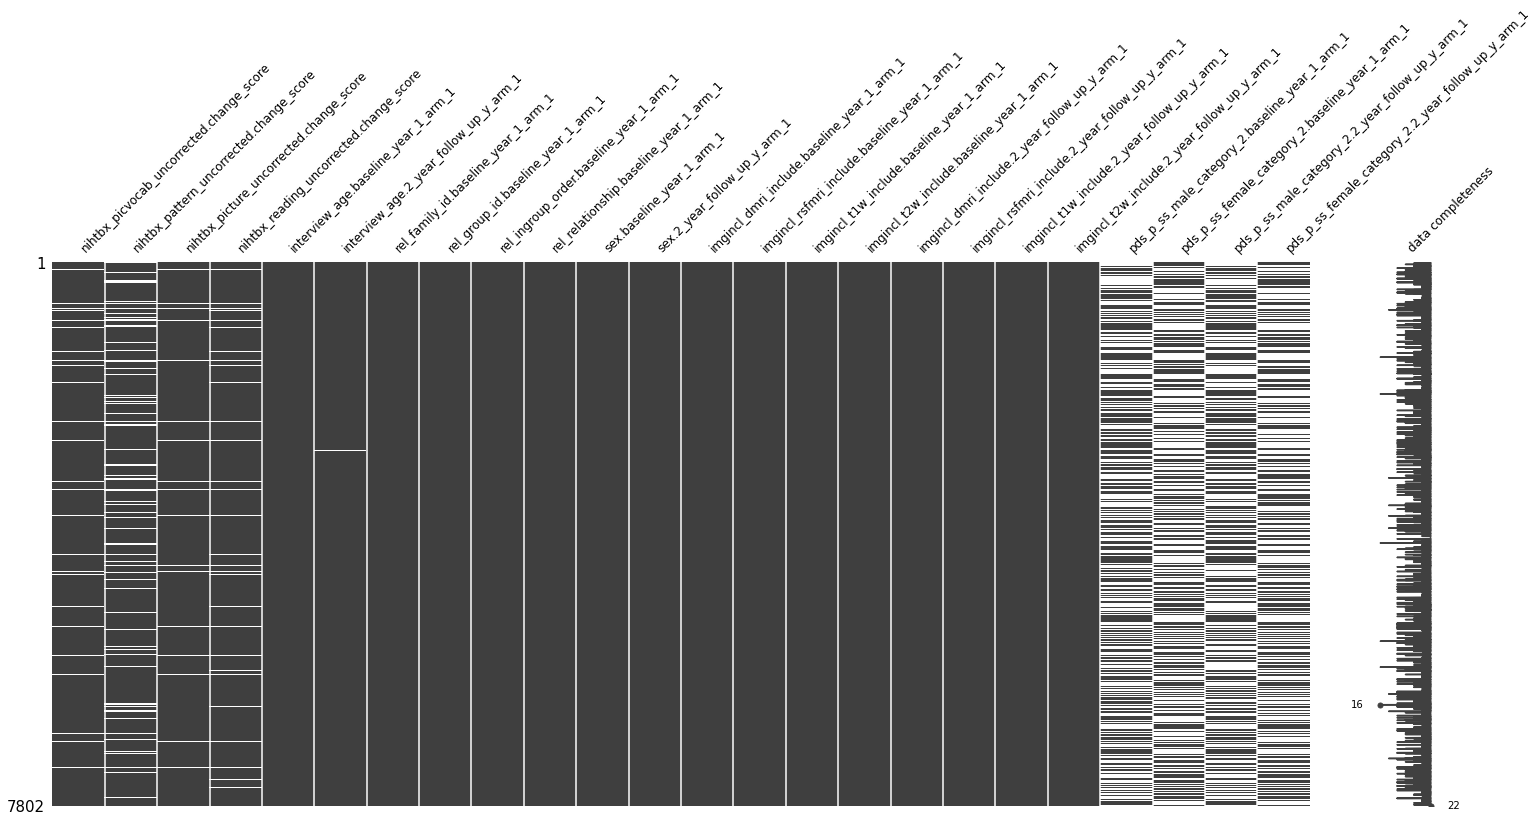

In [9]:
miss_vars = nihtb + age + family + sex + imaging_qc + puberty
matrix_df = df[miss_vars]
msno.matrix(matrix_df, labels=True, fontsize=12)

<AxesSubplot:>

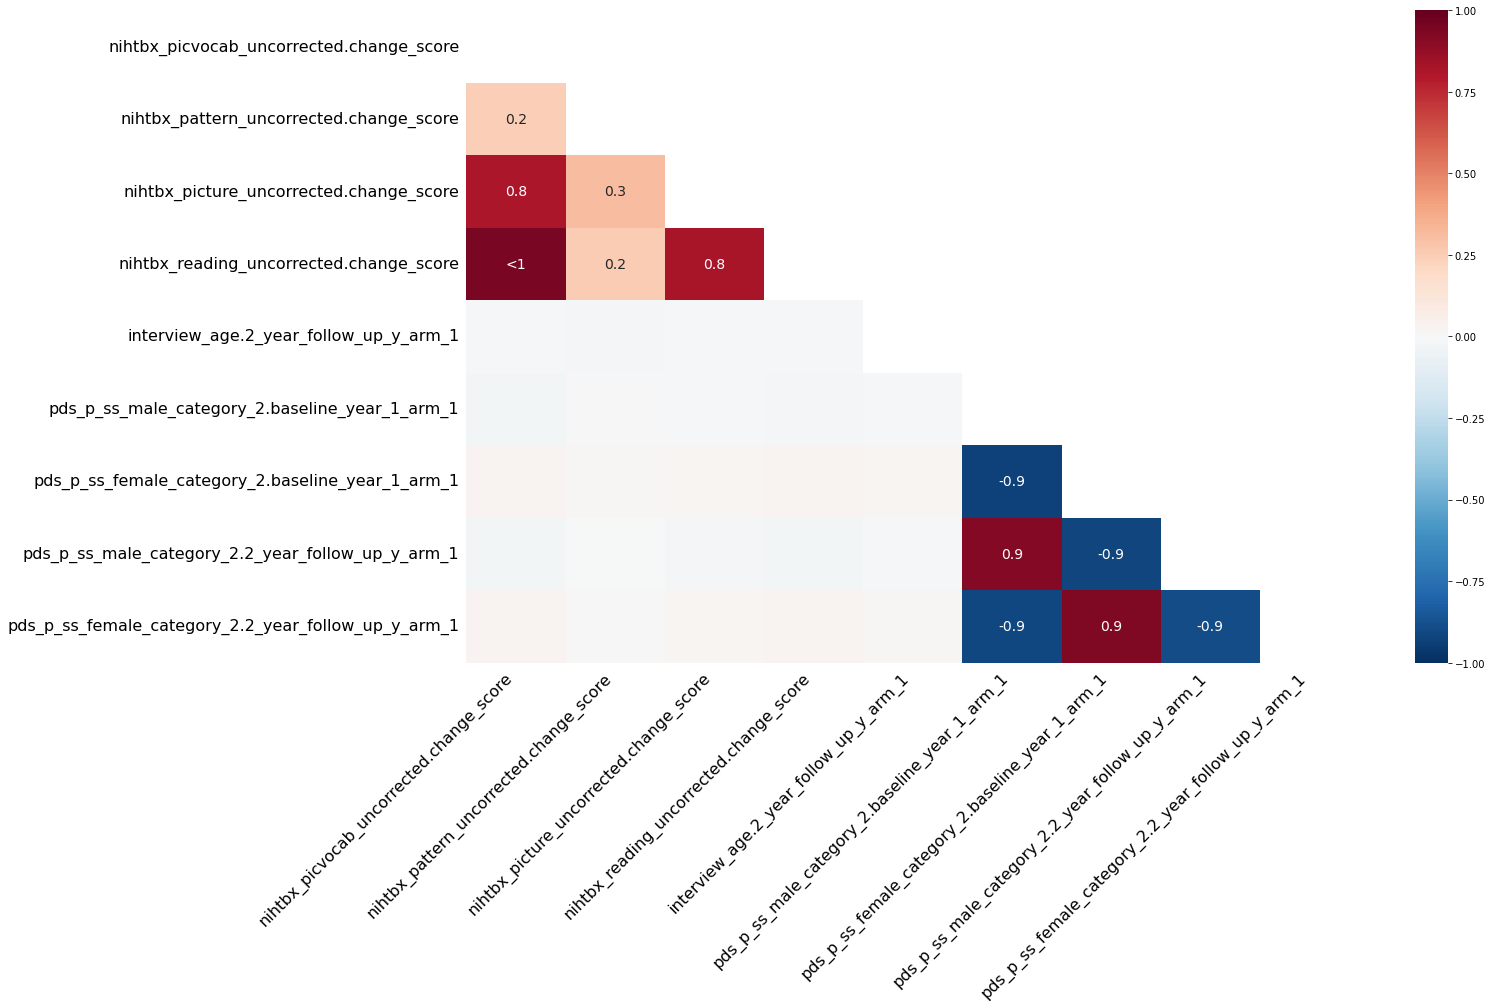

In [10]:
msno.heatmap(matrix_df, cmap="RdBu_r")

In [11]:
deltarsfmri_complete

,rsfmri_var_cdk_banksstslh.change_score,rsfmri_var_cdk_cdaclatelh.change_score,rsfmri_var_cdk_cdmdflh.change_score,rsfmri_var_cdk_cuneuslh.change_score,rsfmri_var_cdk_entorhinallh.change_score,rsfmri_var_cdk_fflh.change_score,rsfmri_var_cdk_ifpalh.change_score,rsfmri_var_cdk_iftlh.change_score,rsfmri_var_cdk_ihclatelh.change_score,rsfmri_var_cdk_loccipitallh.change_score,...,rsfmri_cor_ngd_vs_scs_vtdclh.change_score,rsfmri_cor_ngd_vs_scs_crcxrh.change_score,rsfmri_cor_ngd_vs_scs_thprh.change_score,rsfmri_cor_ngd_vs_scs_cderh.change_score,rsfmri_cor_ngd_vs_scs_ptrh.change_score,rsfmri_cor_ngd_vs_scs_plrh.change_score,rsfmri_cor_ngd_vs_scs_hprh.change_score,rsfmri_cor_ngd_vs_scs_agrh.change_score,rsfmri_cor_ngd_vs_scs_aarh.change_score,rsfmri_cor_ngd_vs_scs_vtdcrh.change_score
subjectkey,,,,,,,,,,,,,,,,,,,,,
NDAR_INV022ZVCT8,-7.271557,1.501567,-5.524013,29.843322,-3.550152,-2.611997,0.041647,-36.777858,17.049383,6.184523,...,116.486023,13.850180,-83.803703,20.077038,44.336570,-80.314061,-52.735619,-21.377332,-12.257232,49.799082
NDAR_INV08J0E48V,-2.223881,-5.240979,-9.075320,-5.667646,7.719976,6.051621,-14.815545,-0.029449,1.421235,20.066868,...,166.181069,-145.079424,189.331947,-57.259049,-59.905130,-48.188413,-27.172516,36.555634,4.142079,114.431709
NDAR_INV08K0R9C4,26.118972,12.498911,13.114460,26.156202,9.625068,-6.858389,-0.283995,27.554430,28.079332,24.976377,...,46.075911,-6.593419,-43.443913,8.016342,220.288518,-309.871261,-10.427298,177.876336,-52.844657,69.697204
NDAR_INV08P3GNDV,-19.285463,-18.881500,10.129099,-17.839195,-13.933764,-28.568725,-21.057009,-38.510664,-12.607499,-27.855987,...,29.229996,61.156126,73.645136,-11.692797,148.046840,320.070792,-75.951431,47.527283,234.520030,-57.915273
NDAR_INV08R2PTT1,-5.323556,10.238619,-4.421129,22.715603,50.338826,37.824448,16.989153,51.566604,23.914233,30.635702,...,-267.187223,-13.700145,-331.569416,79.947693,-33.653652,-366.316017,-38.295539,-10.518022,100.585246,2825.320541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDAR_INVZTPV9V4Z,-5.611858,13.609606,7.833120,9.609082,-0.815768,-14.634647,1.491930,-45.070342,10.695573,10.999434,...,-157.505840,-27.904322,37.425564,-133.962792,238.473982,-22.633561,-394.037490,-118.334620,425.982545,-4.351281
NDAR_INVZN4F9J96,15.186010,-1.313839,17.213763,23.837840,34.759652,12.735595,-3.325279,-20.370325,10.501695,18.536509,...,75.837708,227.084492,-2.091536,-62.076318,203.876085,85.718673,156.304093,25.105357,236.206114,32.675907
NDAR_INVZPRTF377,-4.740790,-10.762263,2.972405,23.598286,-38.327727,9.747415,11.232246,-18.214790,-15.121762,26.262879,...,106.341305,12.797847,-80.777887,59.968233,-0.042023,-103.411123,104.478928,-31.367785,459.138465,197.838867


In [12]:
sex = pd.get_dummies(df[["sex.baseline_year_1_arm_1", "sex.2_year_follow_up_y_arm_1"]])
sex_cols = list(sex.columns)
df = pd.concat([df, sex], axis=1)
df.drop(
    ["sex.baseline_year_1_arm_1", "sex.2_year_follow_up_y_arm_1"], axis=1, inplace=True
)
mri = pd.get_dummies(
    df[
        [
            "mri_info_manufacturer.baseline_year_1_arm_1",
            "mri_info_manufacturer.2_year_follow_up_y_arm_1",
        ]
    ]
)
mri_cols = list(mri.columns)
df = pd.concat([df, mri], axis=1)
df.drop(
    [
        "mri_info_manufacturer.baseline_year_1_arm_1",
        "mri_info_manufacturer.2_year_follow_up_y_arm_1",
    ],
    axis=1,
    inplace=True,
)
site = pd.get_dummies(
    df[["site_id_l.baseline_year_1_arm_1", "site_id_l.2_year_follow_up_y_arm_1"]]
)
#site_cols = list(site.columns)#
#df = df = pd.concat([df, site], axis=1)
#df.drop(
#    ["site_id_l.baseline_year_1_arm_1", "site_id_l.2_year_follow_up_y_arm_1"],
#    axis=1,
#    inplace=True,
#)
site_cols = ["site_id_l.baseline_year_1_arm_1", "site_id_l.2_year_follow_up_y_arm_1"]

What am I going to do?
If I add baseline and 2yfu imaging QC variables then any value less than 2 is an exclude.
and I can convert everything less than 2 to np.nan to use for missingness assessments. 
Need to find out what the "mean motion" value is. FD? yes, in mm.

In [13]:
# build a mini dataset that represents missingness on each variable
keep = nihtb + puberty + demographics + age + family + sex_cols + mri_cols + site_cols
miss_df = df[keep]

In [14]:
missing = miss_df.isna().replace({True: 1, False: 0})

for col1 in missing:
    for col2 in miss_df:
        if col1 != col2:
            temp_df = pd.concat([missing[col1], miss_df[col2]], axis=1)
            temp_df.dropna(how="any", inplace=True)
            if len(miss_df[col2].dropna().unique()) == 2:
                mcc = matthews_corrcoef(temp_df[col1].values, temp_df[col2].values)
                print(
                    f"{col1} missingness assoc with {col2} value\nmcc = {np.round(mcc, 4)}"
                )
            else:
                pbr = sstats.pointbiserialr(temp_df[col1].values, temp_df[col2].values)
                if pbr[1] < 0.01:
                    print(
                        f"{col1} missingness assoc with {col2} value\nr = {np.round(pbr[0], 4)}\t\tp = {np.round(pbr[1], 4)}"
                    )
                else:
                    pass
        else:
            pass

missing.corr(method="kendall")

# grab imaging var names bc missingness is redundant across those
dmri_rgx = 'dmri.*'
dmri_cols = df.filter(regex=dmri_rgx, axis=1).columns
smri_rgx = 'smri.*'
smri_cols = df.filter(regex=smri_rgx, axis=1).columns
fmri_rgx = 'rsfmri.*'
fmri_cols = df.filter(regex=fmri_rgx, axis=1).columns

In [15]:
# using ABCD's inclusion criteria to further mask the data
# add include from baseline and y2, then convert all values <2 to nan

modalities = ["t1w", "dmri", "t2w", "rsfmri"]
for modality in modalities:
    missing = pd.Series(index=miss_df.index)
    missing = (
        df[f"imgincl_{modality}_include.baseline_year_1_arm_1"]
        + df[f"imgincl_{modality}_include.2_year_follow_up_y_arm_1"]
    )
    for i in miss_df.index:
        if missing.loc[i] == 2.0:
            miss_df.loc[i, f"{modality}_missing"] = 1
        else:
            miss_df.loc[i, f"{modality}_missing"] = np.nan

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_25067/2395865798.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  missing = pd.Series(index=miss_df.index)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

<AxesSubplot:>

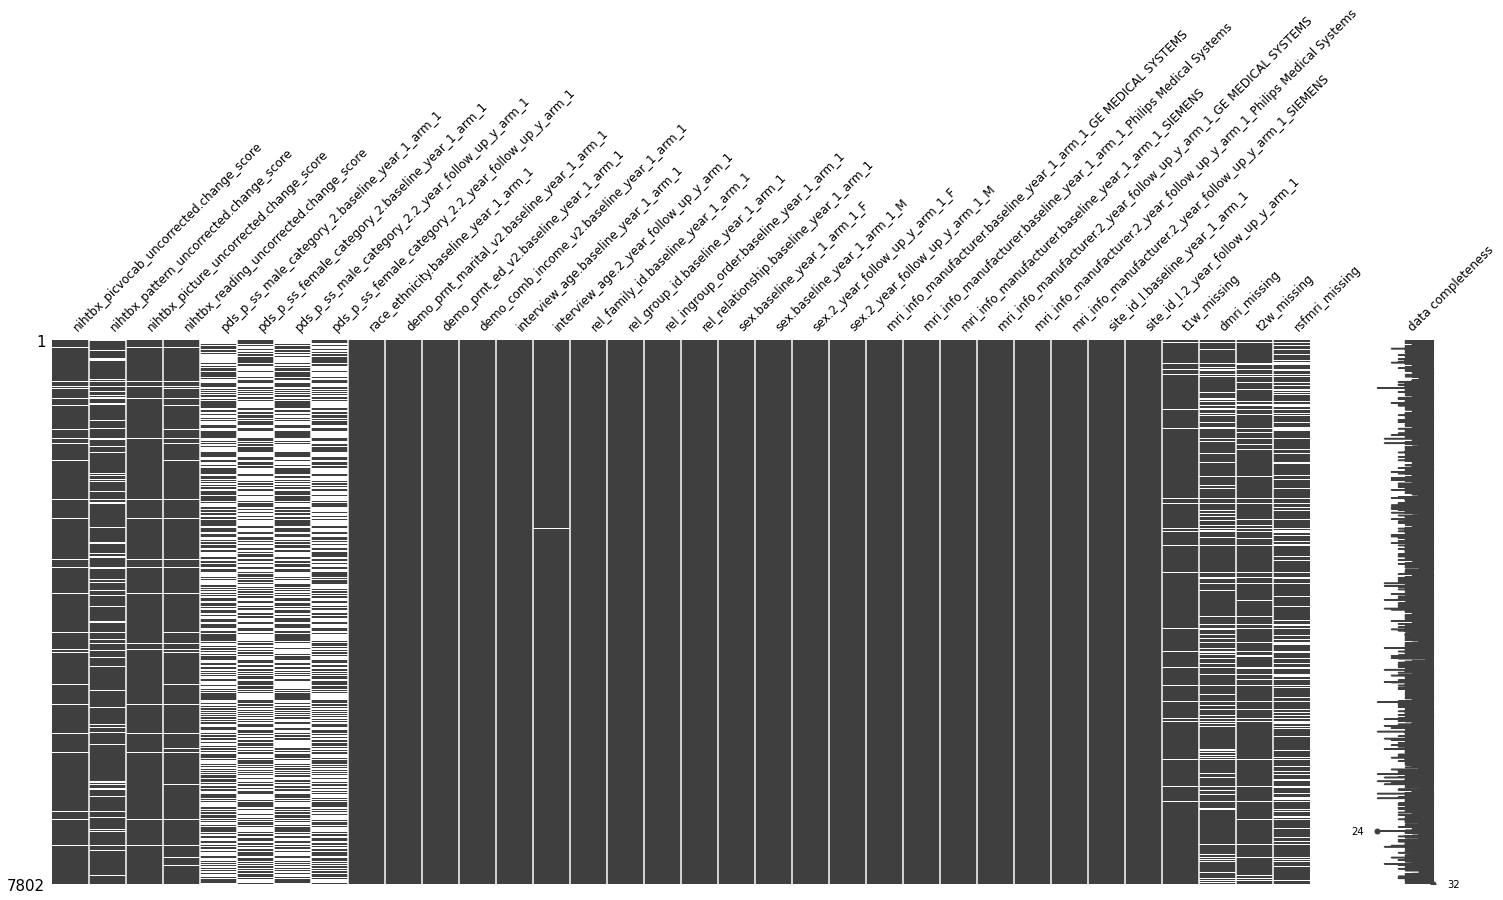

In [16]:
msno.matrix(miss_df, labels=True, fontsize=12)

In [17]:
# calculate percent misingness on each var
pct_miss = miss_df.isna().sum() / len(miss_df.index)

In [18]:
deltarsfmri_complete

,rsfmri_var_cdk_banksstslh.change_score,rsfmri_var_cdk_cdaclatelh.change_score,rsfmri_var_cdk_cdmdflh.change_score,rsfmri_var_cdk_cuneuslh.change_score,rsfmri_var_cdk_entorhinallh.change_score,rsfmri_var_cdk_fflh.change_score,rsfmri_var_cdk_ifpalh.change_score,rsfmri_var_cdk_iftlh.change_score,rsfmri_var_cdk_ihclatelh.change_score,rsfmri_var_cdk_loccipitallh.change_score,...,rsfmri_cor_ngd_vs_scs_vtdclh.change_score,rsfmri_cor_ngd_vs_scs_crcxrh.change_score,rsfmri_cor_ngd_vs_scs_thprh.change_score,rsfmri_cor_ngd_vs_scs_cderh.change_score,rsfmri_cor_ngd_vs_scs_ptrh.change_score,rsfmri_cor_ngd_vs_scs_plrh.change_score,rsfmri_cor_ngd_vs_scs_hprh.change_score,rsfmri_cor_ngd_vs_scs_agrh.change_score,rsfmri_cor_ngd_vs_scs_aarh.change_score,rsfmri_cor_ngd_vs_scs_vtdcrh.change_score
subjectkey,,,,,,,,,,,,,,,,,,,,,
NDAR_INV022ZVCT8,-7.271557,1.501567,-5.524013,29.843322,-3.550152,-2.611997,0.041647,-36.777858,17.049383,6.184523,...,116.486023,13.850180,-83.803703,20.077038,44.336570,-80.314061,-52.735619,-21.377332,-12.257232,49.799082
NDAR_INV08J0E48V,-2.223881,-5.240979,-9.075320,-5.667646,7.719976,6.051621,-14.815545,-0.029449,1.421235,20.066868,...,166.181069,-145.079424,189.331947,-57.259049,-59.905130,-48.188413,-27.172516,36.555634,4.142079,114.431709
NDAR_INV08K0R9C4,26.118972,12.498911,13.114460,26.156202,9.625068,-6.858389,-0.283995,27.554430,28.079332,24.976377,...,46.075911,-6.593419,-43.443913,8.016342,220.288518,-309.871261,-10.427298,177.876336,-52.844657,69.697204
NDAR_INV08P3GNDV,-19.285463,-18.881500,10.129099,-17.839195,-13.933764,-28.568725,-21.057009,-38.510664,-12.607499,-27.855987,...,29.229996,61.156126,73.645136,-11.692797,148.046840,320.070792,-75.951431,47.527283,234.520030,-57.915273
NDAR_INV08R2PTT1,-5.323556,10.238619,-4.421129,22.715603,50.338826,37.824448,16.989153,51.566604,23.914233,30.635702,...,-267.187223,-13.700145,-331.569416,79.947693,-33.653652,-366.316017,-38.295539,-10.518022,100.585246,2825.320541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDAR_INVZTPV9V4Z,-5.611858,13.609606,7.833120,9.609082,-0.815768,-14.634647,1.491930,-45.070342,10.695573,10.999434,...,-157.505840,-27.904322,37.425564,-133.962792,238.473982,-22.633561,-394.037490,-118.334620,425.982545,-4.351281
NDAR_INVZN4F9J96,15.186010,-1.313839,17.213763,23.837840,34.759652,12.735595,-3.325279,-20.370325,10.501695,18.536509,...,75.837708,227.084492,-2.091536,-62.076318,203.876085,85.718673,156.304093,25.105357,236.206114,32.675907
NDAR_INVZPRTF377,-4.740790,-10.762263,2.972405,23.598286,-38.327727,9.747415,11.232246,-18.214790,-15.121762,26.262879,...,106.341305,12.797847,-80.777887,59.968233,-0.042023,-103.411123,104.478928,-31.367785,459.138465,197.838867


In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
smri_comp = pca.fit_transform(deltasmri_complete)
rsfmri_comp = pca.fit_transform(deltarsfmri_complete)
rsi_comp = pca.fit_transform(deltarsi_complete)
dti_comp = pca.fit_transform(deltadti_complete)

In [20]:
smri_components = pd.DataFrame(index=deltasmri_complete.index, 
                               data=smri_comp, 
                               columns=['smri1', 'smri2', 'smri3'])
rsfmri_components = pd.DataFrame(index=deltarsfmri_complete.index, 
                                 data=rsfmri_comp, 
                                 columns=['rsfmri1', 'rsfmri2', 'rsfmri3'])
rsi_components = pd.DataFrame(index=deltarsi_complete.index, 
                              data=rsi_comp, 
                              columns=['rsi1', 'rsi2', 'rsi3'])
dti_components = pd.DataFrame(index=deltadti_complete.index, 
                              data=dti_comp, 
                              columns=['dti1', 'dti2', 'dti3'])

In [21]:
miss_w_comps = pd.concat([miss_df, smri_components, rsfmri_components, rsi_components, dti_components], axis=1)

<AxesSubplot:>

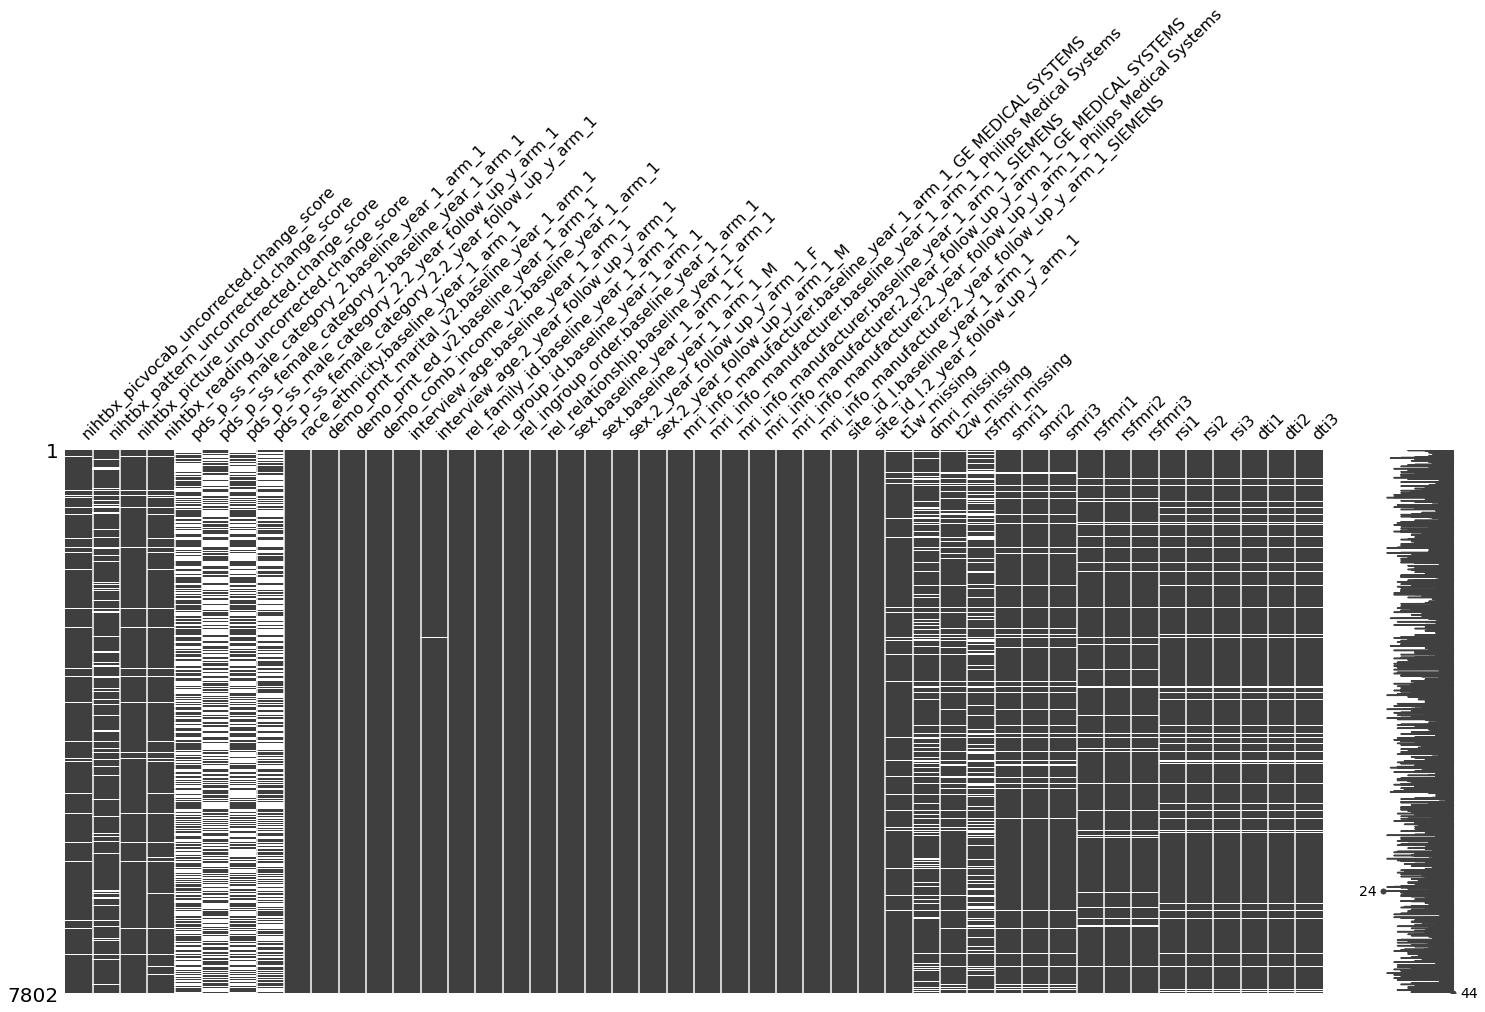

In [22]:
msno.matrix(miss_w_comps)

<AxesSubplot:>

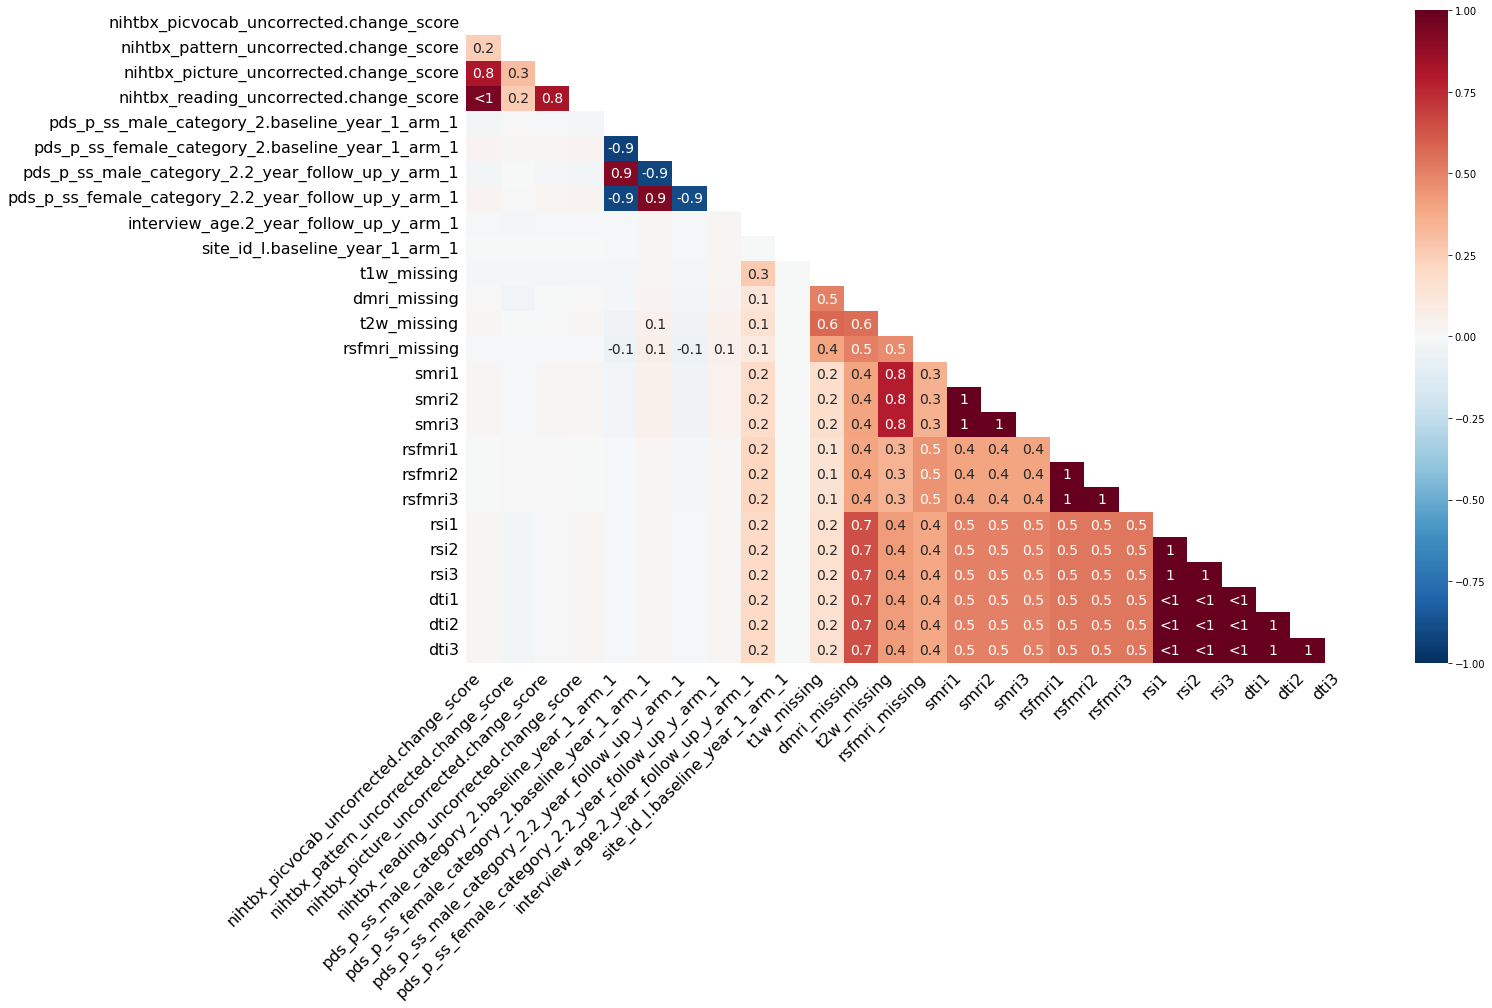

In [23]:
msno.heatmap(miss_w_comps, cmap='RdBu_r')

In [24]:
miss_w_comps.to_csv(join(PROJ_DIR, DATA_DIR, 'img_components_and_data.csv'))

In [25]:
miss_prop = miss_w_comps.isna().sum() / len(miss_w_comps.index)

In [26]:
miss_prop.sort_values()

mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS            0.000000
sex.2_year_follow_up_y_arm_1_M                                            0.000000
sex.2_year_follow_up_y_arm_1_F                                            0.000000
sex.baseline_year_1_arm_1_M                                               0.000000
sex.baseline_year_1_arm_1_F                                               0.000000
rel_relationship.baseline_year_1_arm_1                                    0.000000
rel_ingroup_order.baseline_year_1_arm_1                                   0.000000
rel_group_id.baseline_year_1_arm_1                                        0.000000
rel_family_id.baseline_year_1_arm_1                                       0.000000
interview_age.baseline_year_1_arm_1                                       0.000000
mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS                       0.000000
demo_comb_income_v2.baseline_year_1_arm_1                                 0.000000
demo

In [29]:
m_base_puberty_missing = df['pds_p_ss_male_category_2.baseline_year_1_arm_1'].isna().sum() 
f_base_puberty_missing = df['pds_p_ss_female_category_2.baseline_year_1_arm_1'].isna().sum()
(m_base_puberty_missing + f_base_puberty_missing) / len(df.index)

1.0326839271981543

In [30]:
len(df.index)

7802